In [1]:
# Import The Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install xlrd

     |████████████████████████████████| 96 kB 5.1 MB/s             


In [3]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 8.4 MB/s            


In [4]:
# Import The Dataset
df = pd.read_excel("retail_example.xlsx", engine="openpyxl")
df = df[df['CustomerID'].notna()]

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Sample the dataset
df_fix = df.sample(10000, random_state = 42)

In [7]:
# Convert to show date only
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

In [8]:
# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

In [9]:
# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

In [10]:
# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

In [11]:
# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [15]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


In [16]:
# Import library to normalize the data
from sklearn.preprocessing import StandardScaler

In [17]:
# Initialize the Object
scaler = StandardScaler()

In [18]:
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

In [19]:
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0.  0.]
[1. 1. 1.]


In [20]:
!pip install seaborn

     |████████████████████████████████| 292 kB 8.4 MB/s            


In [21]:
import seaborn as sns

In [51]:
# Set 3 colors to legend 
sns.color_palette("Greys", 3)

[(0.8501191849288735, 0.8501191849288735, 0.8501191849288735),
 (0.586082276047674, 0.586082276047674, 0.586082276047674),
 (0.3174163783160323, 0.3174163783160323, 0.3174163783160323)]

In [52]:
palette=sns.color_palette("Greys", 3)

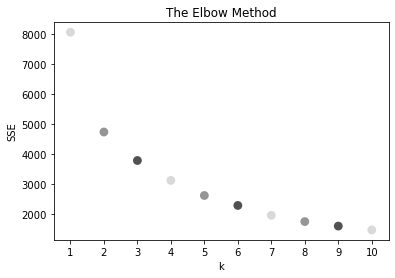

In [53]:
# Elbow Method
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()), palette=palette )
plt.show()

In [54]:
# fit the model
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

In [56]:
# create clusters
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         46.25      7.71        165.79   924
1         47.62      1.61         21.51   811
2        227.29      1.64         28.70   955

In [57]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

In [58]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,0,Recency,-0.493794
1,12348.0,2,Recency,1.232949
2,12349.0,0,Recency,-0.994917
3,12352.0,0,Recency,-0.012582
4,12354.0,2,Recency,1.155005


/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

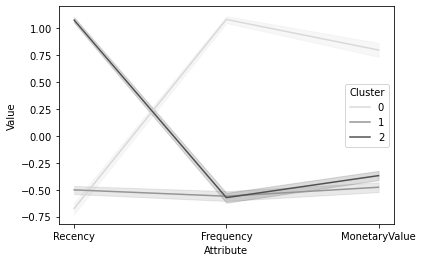

In [59]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt, palette=palette)